### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from difference_methods import one_point_estimate, two_point_estimate, coordinate_estimate
from linear_zeroth_function import Linear_Zeroth
from sigmoid_zeroth_function import Sigmoid_Zeroth
from relu_zeroth_function import ReLU_Zeroth

### Data preprocessing

In [2]:
# Load training data
data_train = pd.read_csv('pendigits.csv')

print(data_train)

       input1  input2  input3  input4  input5  input6  input7  input8  input9  \
0          47     100      27      81      57      37      26       0       0   
1           0      89      27     100      42      75      29      45      15   
2           0      57      31      68      72      90     100     100      76   
3           0     100       7      92       5      68      19      45      86   
4           0      67      49      83     100     100      81      80      60   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
10987      36     100      24      70       0      38      49      33      95   
10988      16      75      41     100      52      64      32      27       0   
10989      56     100      27      79       0      39      12       0      66   
10990      19     100       0      61       3      23      48       0      97   
10991      38     100      37      81      12      55       0      28      52   

       input10  input11  in

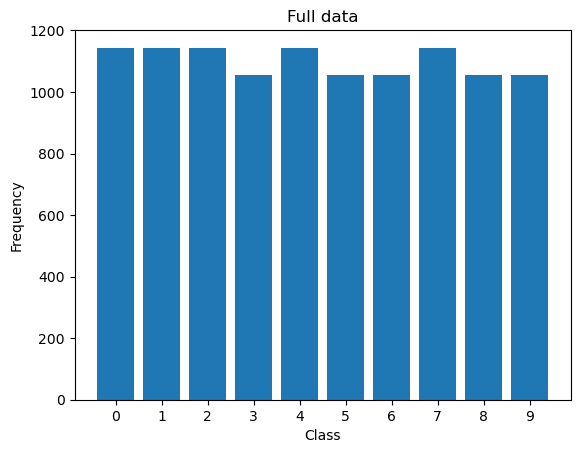

In [3]:
# extract frequency of each class
class_freq = data_train['class'].value_counts()
class_freq = list(class_freq.sort_index())

nb_classes = len(class_freq)
nb_features = data_train.shape[1]-1

# Visual data
graph = plt.bar(list(range(nb_classes)), class_freq)
plt.xticks(list(range(nb_classes)))
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Full data')

plt.show() # balanced data set

In [4]:
# Preprocess data for training

# Convert pandas dataframe to array
data_train_array = data_train.values

# Split x (features) and y (targets)
x_array = data_train_array[:, :nb_features]
y_array = data_train_array[:, nb_features]

# Tensorify
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

print(X.shape)

torch.Size([10992, 16])


### Network Setup

In [5]:
# INPUT/OUTPUT layer sizes
INPUT_NEURONS = nb_features
OUTPUT_NEURONS = nb_classes

In [12]:
# TODO: choose hyperparam ranges
# Hyperparameters
# Layer sizes
hidden_neurons_range = [12]

# Mu
mu_range = [0.001]

# N
n_range = [100]

# Constants
DIFFERENCE_METHOD = 'coord'

In [24]:
# Network architectures: 1 hidden layer

# Activation functions
# Normal network with sigmoid
def create_standard_sigmoid_network(hidden_neurons, mu, n):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        torch.nn.Linear(INPUT_NEURONS, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, OUTPUT_NEURONS)
    )

# Full Zeroth Order sigmoid
def create_zeroth_sigmoid_network(hidden_neurons, mu, n):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        Linear_Zeroth(INPUT_NEURONS, hidden_neurons, bias=False, difference_method=DIFFERENCE_METHOD, mu=mu, n=n),
        Sigmoid_Zeroth(difference_method=DIFFERENCE_METHOD, mu=mu, n=n),
        Linear_Zeroth(hidden_neurons, OUTPUT_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=mu, n=n)
)

# Normal network with relu
def create_standard_relu_network(hidden_neurons, mu, n):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        torch.nn.Linear(INPUT_NEURONS, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, OUTPUT_NEURONS)
    )

# Full Zeroth Order relu
def create_zeroth_relu_network(hidden_neurons, mu, n):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        Linear_Zeroth(INPUT_NEURONS, hidden_neurons, bias=False, difference_method=DIFFERENCE_METHOD, mu=mu, n=n),
        ReLU_Zeroth(difference_method=DIFFERENCE_METHOD, mu=mu, n=n),
        Linear_Zeroth(hidden_neurons, OUTPUT_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=mu, n=n),
)

# TODO: uncomment this
# network_funs = [
#     ("standard_sigmoid", create_standard_sigmoid_network),
#     ("zeroth_sigmoid", create_zeroth_sigmoid_network),
#     ("standard_relu", create_standard_relu_network),
#     ("zeroth_relu", create_zeroth_relu_network),
# ]

# TODO: comment this
network_funs = [
    ("standard_sigmoid", create_standard_sigmoid_network),
    ("standard_relu", create_standard_relu_network),
]

### Train and Plot Losses

In [41]:
# Training hyperparameters
# Training constants
LR = 0.01
NUM_EPOCH = 1000

# Loss function -> could be hyperparam too
loss_func = torch.nn.CrossEntropyLoss()

In [39]:
# Plot or save?
plot = False # plot = False => save

path = "C:\\Opti Project\\Optimisation_ML_Project\\simulations\\plots\\"

In [40]:
# Train each network and plot the loss: 1 hidden layer networks
for hidden_neurons in hidden_neurons_range:
    for mu in mu_range:
        for n in n_range:
            plt.figure()
            network_ref = create_standard_sigmoid_network(hidden_neurons, mu, n) # used to init all nets with same weights
    
            for name, network_fun in network_funs:
                print(f"Network: {name}, HIDDEN_NEURONS: {hidden_neurons}, Mu: {mu}, N: {n} \n=========")

                # Create new instance of network
                network = network_fun(hidden_neurons, mu, n)

                # Optimiser
                optimiser = torch.optim.SGD(network.parameters(), lr=LR)

                # store all losses for visualisation
                all_losses = []

                # train a neural network
                for epoch in range(NUM_EPOCH):
                    # Perform forward pass
                    Y_pred = network(X)
                    # Compute loss
                    loss = loss_func(Y_pred, Y)
                    all_losses.append(loss.item())

                    # print progress
                    if epoch % 50 == 0:
                        # convert three-column predicted Y values to one column for comparison
                        _, predicted = torch.max(torch.nn.functional.softmax(Y_pred,1), 1)
                        # calculate and print accuracy
                        total = predicted.size(0)
                        correct = predicted.data.numpy() == Y.data.numpy()
                        # Print
                        print('Epoch [%d / %d] Loss: %.4f  Accuracy: %.2f %%'
                            % (epoch + 1, NUM_EPOCH, loss.item(), 100 * sum(correct)/total))

                    # Clear the gradients before running the backward pass.
                    network.zero_grad()
                    # Perform backward pass
                    loss.backward()
                    # Step optimiser
                    optimiser.step()

                # Plot
                plt.plot(all_losses)
                
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend(["Std sigmoid", "Std relu"]) # TODO: update when all 4 methods
            if plot:
                plt.show()
            else:
                plt.savefig(f"{path}hn{hidden_neurons}_mu{mu}_n{n}.png")
                plt.close()

Network: standard_sigmoid, HIDDEN_NEURONS: 12, Mu: 0.001, N: 100 
Epoch [1 / 100] Loss: 2.4091  Accuracy: 9.43 %
Epoch [51 / 100] Loss: 2.2831  Accuracy: 16.11 %
Network: standard_relu, HIDDEN_NEURONS: 12, Mu: 0.001, N: 100 
Epoch [1 / 100] Loss: 19.6642  Accuracy: 8.47 %
Epoch [51 / 100] Loss: 1.7130  Accuracy: 36.67 %
